In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import pickle
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
df = pd.read_csv('/Users/jchang153/Documents/UCLA-CAM/GV KG/Data/Tweets/All/bigbabies/bigbaby_r_t_30_s.csv')

## Creating different tweet dataframes for each month

In [97]:
df['date'] = pd.to_datetime(df['date'])

In [98]:
start_month = pd.Timestamp('2020-03')
end_month = pd.Timestamp('2021-06')
all_months = pd.period_range(start_month, end_month, freq='M')

In [99]:
# Create a dictionary to store DataFrames by month
dfs_by_month = {}

# Iterate through each month and filter tweets
for month in all_months:
    start_date = month.to_timestamp()
    end_date = month.to_timestamp(how='end')
    filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    dfs_by_month[str(month)] = filtered_df

### Do the same as in "user network.ipynb" but with monthly dataframes

In [77]:
black_topics = [1,2,3,4,7,8,9,11,13,15,19,20,21,23,25,27,31,34,36,38,40,41,42,44,45,46,47,48,50,
51,52,56,62,63,64,66,68,70,71,73,75,76,78,82,83,84,86,88,92,93,94,101,102,105,106,
107,109,111,114,117,119,120, 121,122,123,124,125,126,131,132,133,137,140,143,144,145,
146,147,149,150,151,153,154,155,157,160,162,163,164,165,166,168,169,171,172,177,
178,179,180,184,186,187,188,191,193,196,200,202,203,206,208,211,212,216,218,220,222,
223,224,225,226,228,229,230,233,235,242,244,245,250,251,253,254,255,256,259,260,261,266,
268,269]

In [84]:
for month in tqdm(all_months):
    df_f = dfs_by_month[str(month)]
    
    tweet_counts = df_f.groupby('user_id').size().reset_index(name='num')
    tweet_counts_filter = tweet_counts[tweet_counts['num'] >= 10]
    users = list(tweet_counts_filter['user_id'])
    
    df_f = df_f[df_f['user_id'].isin(users)]
    
    
    
    topic_scores = {}

    for _, row in df_f.iterrows():
        user_id = row['user_id']
        tweet_id = row['tweet_id']
        topic_scores.setdefault(user_id, {})
        topic_scores[user_id][tweet_id] = {col: row[f'{col}'] for col in range(270)}

    relations = []

    for user1 in tqdm(users):
        for user2 in users:
            if user1 == user2:
                relations.append([user1, user2, 0])
                continue

            scores1 = topic_scores.get(user1, {})
            scores2 = topic_scores.get(user2, {})

            w = 0

            for tweet_scores1 in scores1.values():
                for tweet_scores2 in scores2.values():
                    for top in black_topics:
                        w += tweet_scores1.get(top, 0) * tweet_scores2.get(top, 0)

            relations.append([user1, user2, w])

    with open(f'./users by month/relations_{month}.pkl', 'wb') as f:
        pickle.dump(relations, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [09:08<00:00, 34.26s/it]


### Calculate Centralities

In [94]:
for month in all_months:
    month = str(month)
    df_month = dfs_by_month[month]
    user_sents = df_month.groupby('user_id')['sent'].mean().reset_index(name='sent')
    tweet_counts = df_month.groupby('user_id').size().reset_index(name='num')
    
    with open(f'./users by month/relations_{month}.pkl', 'rb') as f:
        relations = pickle.load(f)

    G = nx.Graph()

    for user1, user2, weight in tqdm(relations):
        G.add_edge(user1, user2, weight=weight)

    weighted_degrees = {node: sum(weight for _, _, weight in G.edges(node, data='weight')) for node in G.nodes()}
    eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')

    centrality_data = {
        'user': [int(node) for node in G.nodes()],
        'eigenvector centrality': [eigenvector_centrality[node] for node in G.nodes()],
        'weighted degree': [weighted_degrees[node] for node in G.nodes()],
        'num tweets': [int(tweet_counts[tweet_counts['user_id'] == node].iloc[0]['num']) for node in G.nodes()],
        'followers': [int(df[df['user_id'] == node].iloc[0]['followers_count']) for node in G.nodes()],
        'screen name': [df[df['user_id'] == node].iloc[0]['screen_name'] for node in G.nodes()],
        'average sent': [user_sents[user_sents['user_id'] == node].iloc[0]['sent'] for node in G.nodes()]
    }
    df_c = pd.DataFrame(centrality_data)
    df_c2 = df_c.sort_values(by='weighted degree', ascending=False)
    df_c2['prod'] = df_c2['weighted degree'] * df_c2['followers']
    # df_c3 = df_c2.sort_values(by='prod', ascending=False)
    
    df_c2.to_csv(f'./users by month/user_network_{month}.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 347210.60it/s]


## Now calculate monthly user networks for users who tweeted at least 5 times in those months

In [2]:
df = pd.read_csv('/Users/jchang153/Documents/UCLA-CAM/GV KG/Data/Tweets/All/bigbabies/bigbaby_r_t_30_s.csv')
df['date'] = pd.to_datetime(df['date'])

In [3]:
start_month = pd.Timestamp('2020-03')
end_month = pd.Timestamp('2021-06')
all_months = pd.period_range(start_month, end_month, freq='M')

In [4]:
# Create a dictionary to store DataFrames by month
dfs_by_month = {}

# Iterate through each month and filter tweets
for month in all_months:
    start_date = month.to_timestamp()
    end_date = month.to_timestamp(how='end')
    filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    dfs_by_month[str(month)] = filtered_df

In [5]:
df_c = pd.read_csv('user_network_black.csv')

In [6]:
top_5_users = df_c.sort_values(by='eigenvector centrality', ascending=False).iloc[:5]

In [7]:
top_5_users

,user,eigenvector centrality,weighted degree,num tweets,followers,screen name,prod,average sent
285,59047876,0.329947,9518.461504,405,163,sophiatseliem,1.551509e+06,-0.191473
448,199120695,0.297871,8053.441088,417,885,Nityalakshmi,7.127295e+06,-0.223182
733,2185190036,0.223639,5967.849716,371,1254,mattlogical,7.483684e+06,-0.079958
453,205240369,0.144378,3537.263125,102,282,Progress_orDie,9.975082e+05,0.026492
574,473384312,0.128157,3208.616266,120,683,dandlionalchemy,2.191485e+06,0.010796


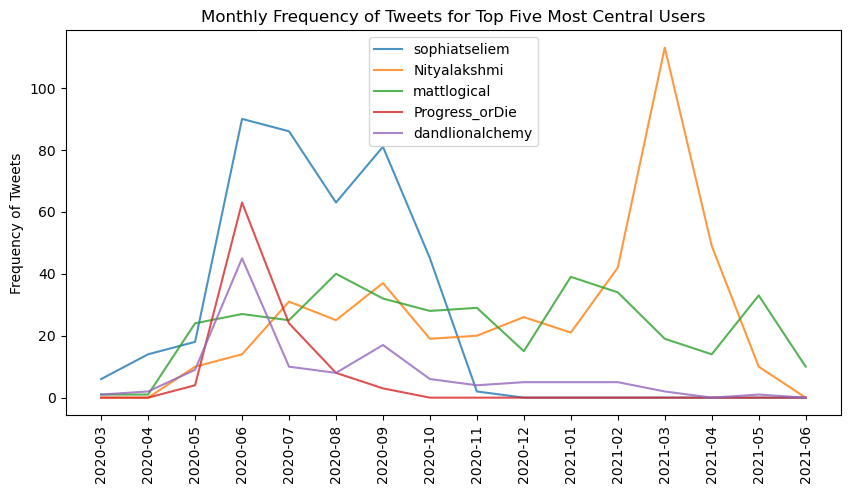

In [12]:
plt.figure(figsize=(10,5))

for user in list(top_5_users['user']):
    count = []
    for month in all_months:
        df_month = dfs_by_month[str(month)]
        count.append(len(df_month[df_month['user_id'] == user]))
    screen_name = df[df['user_id'] == user].iloc[0]['screen_name']
    plt.plot([str(month) for month in all_months], count, label=f'{screen_name}', alpha=0.8)

plt.xticks(rotation=90)
plt.ylabel('Frequency of Tweets')
plt.title('Monthly Frequency of Tweets for Top Five Most Central Users')
plt.legend()
plt.show()

In [16]:
for i in df[df['user_id'] == 199120695]['text']:
    print(i, '\n')

i haven’t had to deal with ☝️ perverted coveting pinteristing mistress &amp; her family- it’s been horny encinitas/sand… https://t.co/texlm9toen 

if there had been one 7 women driven dyke gang rape at banning jail w/ clothes scissored off - that might have been… https://t.co/gxadgjvhcq 

please make reparations on all mother’s day separations in sandiego and riverside co by “married &amp; dating” sex cult… https://t.co/wwhryeolwe 

we need reparations for local officer bribes w/ lexus &amp; x team now. 
courts failed my family- proved incompetency a… https://t.co/6wekmhpbyw 

so many gorgeous women are held captive by perverted officers &amp; attys for court greed. why is this allowed?… https://t.co/vitruc3epb 

the problem with mostly dykes running women’s jails- is there’s no woman’s advocate. getting attacked by a gang of… https://t.co/ee0mwsuvhc 

how many moms are suicided from court anually? 
all families need reparations for mother lost- main caretaker and h… https://t.co/rggrv

In [17]:
black_topics = [1,2,3,4,7,8,9,11,13,15,19,20,21,23,25,27,31,34,36,38,40,41,42,44,45,46,47,48,50,
51,52,56,62,63,64,66,68,70,71,73,75,76,78,82,83,84,86,88,92,93,94,101,102,105,106,
107,109,111,114,117,119,120, 121,122,123,124,125,126,131,132,133,137,140,143,144,145,
146,147,149,150,151,153,154,155,157,160,162,163,164,165,166,168,169,171,172,177,
178,179,180,184,186,187,188,191,193,196,200,202,203,206,208,211,212,216,218,220,222,
223,224,225,226,228,229,230,233,235,242,244,245,250,251,253,254,255,256,259,260,261,266,
268,269]

In [23]:
for month in all_months:
    df_month = dfs_by_month[str(month)]
    tweet_counts = df_month.groupby('user_id').size().reset_index(name='num')
    tweet_counts_filter = tweet_counts[tweet_counts['num'] >= 5]
    print(len(tweet_counts_filter['user_id']))

28
34
220
870
188
176
148
99
68
33
92
44
41
63
43
16


In [24]:
for month in tqdm(all_months):
    df_f = dfs_by_month[str(month)]
    
    tweet_counts = df_f.groupby('user_id').size().reset_index(name='num')
    tweet_counts_filter = tweet_counts[tweet_counts['num'] >= 5]
    users = list(tweet_counts_filter['user_id'])
    
    df_f = df_f[df_f['user_id'].isin(users)]
    
    print(f'we are on month {str(month)} and there are {len(users)} users with at least 5 tweets')
    
    topic_scores = {}

    for _, row in df_f.iterrows():
        user_id = row['user_id']
        tweet_id = row['tweet_id']
        topic_scores.setdefault(user_id, {})
        topic_scores[user_id][tweet_id] = {col: row[f'{col}'] for col in range(270)}

    relations = []

    for user1 in tqdm(users):
        for user2 in users:
            if user1 == user2:
                relations.append([user1, user2, 0])
                continue

            scores1 = topic_scores.get(user1, {})
            scores2 = topic_scores.get(user2, {})

            w = 0

            for tweet_scores1 in scores1.values():
                for tweet_scores2 in scores2.values():
                    for top in black_topics:
                        w += tweet_scores1.get(top, 0) * tweet_scores2.get(top, 0)

            relations.append([user1, user2, w])

    with open(f'./usersbymonth-black-5/relations_{month}.pkl', 'wb') as f:
        pickle.dump(relations, f)

  0%|                                                                                                          | 0/16 [00:00<?, ?it/s]

we are on month 2020-03 and there are 28 users with at least 5 tweets



  6%|██████▏                                                                                           | 1/16 [00:01<00:25,  1.72s/it]

we are on month 2020-04 and there are 34 users with at least 5 tweets



 12%|████████████▎                                                                                     | 2/16 [00:03<00:27,  1.96s/it]

we are on month 2020-05 and there are 220 users with at least 5 tweets



 19%|██████████████████▍                                                                               | 3/16 [01:26<08:25, 38.85s/it]

we are on month 2020-06 and there are 870 users with at least 5 tweets



 25%|███████████████████████▊                                                                       | 4/16 [30:05<2:20:25, 702.10s/it]

we are on month 2020-07 and there are 188 users with at least 5 tweets



 31%|█████████████████████████████▋                                                                 | 5/16 [31:39<1:28:30, 482.75s/it]

we are on month 2020-08 and there are 176 users with at least 5 tweets



 38%|████████████████████████████████████▍                                                            | 6/16 [32:57<57:33, 345.32s/it]

we are on month 2020-09 and there are 148 users with at least 5 tweets



 44%|██████████████████████████████████████████▍                                                      | 7/16 [33:51<37:29, 250.00s/it]

we are on month 2020-10 and there are 99 users with at least 5 tweets



 50%|████████████████████████████████████████████████▌                                                | 8/16 [34:14<23:42, 177.86s/it]

we are on month 2020-11 and there are 68 users with at least 5 tweets



 56%|██████████████████████████████████████████████████████▌                                          | 9/16 [34:26<14:40, 125.82s/it]

we are on month 2020-12 and there are 33 users with at least 5 tweets



 62%|████████████████████████████████████████████████████████████▋                                    | 10/16 [34:28<08:45, 87.60s/it]

we are on month 2021-01 and there are 92 users with at least 5 tweets



 69%|██████████████████████████████████████████████████████████████████▋                              | 11/16 [34:47<05:33, 66.73s/it]

we are on month 2021-02 and there are 44 users with at least 5 tweets



 75%|████████████████████████████████████████████████████████████████████████▊                        | 12/16 [34:51<03:10, 47.69s/it]

we are on month 2021-03 and there are 41 users with at least 5 tweets



 81%|██████████████████████████████████████████████████████████████████████████████▊                  | 13/16 [34:57<01:44, 34.90s/it]

we are on month 2021-04 and there are 63 users with at least 5 tweets



 88%|████████████████████████████████████████████████████████████████████████████████████▉            | 14/16 [35:10<00:56, 28.38s/it]

we are on month 2021-05 and there are 43 users with at least 5 tweets



 94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 15/16 [35:16<00:21, 21.61s/it]

we are on month 2021-06 and there are 16 users with at least 5 tweets



100%|████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [35:17<00:00, 132.32s/it]


In [25]:
for month in all_months:
    month = str(month)
    df_month = dfs_by_month[month]
    user_sents = df_month.groupby('user_id')['sent'].mean().reset_index(name='sent')
    tweet_counts = df_month.groupby('user_id').size().reset_index(name='num')
    
    with open(f'./usersbymonth-black-5/relations_{month}.pkl', 'rb') as f:
        relations = pickle.load(f)

    G = nx.Graph()

    for user1, user2, weight in tqdm(relations):
        G.add_edge(user1, user2, weight=weight)

    weighted_degrees = {node: sum(weight for _, _, weight in G.edges(node, data='weight')) for node in G.nodes()}
    eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')

    centrality_data = {
        'user': [int(node) for node in G.nodes()],
        'eigenvector centrality': [eigenvector_centrality[node] for node in G.nodes()],
        'weighted degree': [weighted_degrees[node] for node in G.nodes()],
        'num tweets': [int(tweet_counts[tweet_counts['user_id'] == node].iloc[0]['num']) for node in G.nodes()],
        'followers': [int(df[df['user_id'] == node].iloc[0]['followers_count']) for node in G.nodes()],
        'screen name': [df[df['user_id'] == node].iloc[0]['screen_name'] for node in G.nodes()],
        'average sent': [user_sents[user_sents['user_id'] == node].iloc[0]['sent'] for node in G.nodes()]
    }
    df_c = pd.DataFrame(centrality_data)
    df_c2 = df_c.sort_values(by='weighted degree', ascending=False)
    df_c2['prod'] = df_c2['weighted degree'] * df_c2['followers']
    # df_c3 = df_c2.sort_values(by='prod', ascending=False)
    
    df_c2.to_csv(f'./usersbymonth-black-5/user_network_{month}.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 735943.68it/s]


## Biweekly user networks for users who tweeted at least 5 times in those biweeks

In [5]:
df = pd.read_csv('/Users/jchang153/Documents/UCLA-CAM/GV KG/Data/Tweets/All/bigbabies/bigbaby_r_t_30_s.csv')
df['date'] = pd.to_datetime(df['date'])

In [44]:
start_date = pd.Timestamp('2020-03-11')
end_date = pd.Timestamp('2021-06-16')
# omit 2021-06-17 because it's a thursday, and we want nice weeks bc 2020-03-11 starts on wednesday

biweekly_dates = pd.date_range(start=start_date, end=end_date, freq='2W-WED')
biweekly_dates = biweekly_dates.union([end_date])

biweekly_dates

DatetimeIndex(['2020-03-11', '2020-03-25', '2020-04-08', '2020-04-22',
               '2020-05-06', '2020-05-20', '2020-06-03', '2020-06-17',
               '2020-07-01', '2020-07-15', '2020-07-29', '2020-08-12',
               '2020-08-26', '2020-09-09', '2020-09-23', '2020-10-07',
               '2020-10-21', '2020-11-04', '2020-11-18', '2020-12-02',
               '2020-12-16', '2020-12-30', '2021-01-13', '2021-01-27',
               '2021-02-10', '2021-02-24', '2021-03-10', '2021-03-24',
               '2021-04-07', '2021-04-21', '2021-05-05', '2021-05-19',
               '2021-06-02', '2021-06-16'],
              dtype='datetime64[ns]', freq='2W-WED')

In [52]:
# Create a dictionary to store DataFrames by month
dfs_by_2w = {}

# Iterate through each month and filter tweets
for i in range(len(biweekly_dates)-1):
    start = biweekly_dates[i]
    end = biweekly_dates[i + 1]
    filtered_df = df[(df['date'] >= start) & (df['date'] <= end)]
    dfs_by_2w[biweekly_dates[i]] = filtered_df

In [46]:
black_topics = [1,2,3,4,7,8,9,11,13,15,19,20,21,23,25,27,31,34,36,38,40,41,42,44,45,46,47,48,50,
51,52,56,62,63,64,66,68,70,71,73,75,76,78,82,83,84,86,88,92,93,94,101,102,105,106,
107,109,111,114,117,119,120, 121,122,123,124,125,126,131,132,133,137,140,143,144,145,
146,147,149,150,151,153,154,155,157,160,162,163,164,165,166,168,169,171,172,177,
178,179,180,184,186,187,188,191,193,196,200,202,203,206,208,211,212,216,218,220,222,
223,224,225,226,228,229,230,233,235,242,244,245,250,251,253,254,255,256,259,260,261,266,
268,269]

In [55]:
for date in biweekly_dates[:-1]:
    df_date = dfs_by_2w[date]
    tweet_counts = df_date.groupby('user_id').size().reset_index(name='num')
    tweet_counts_filter = tweet_counts[tweet_counts['num'] >= 5]
    print(len(tweet_counts_filter['user_id']))

24
7
10
11
19
432
427
131
79
79
49
61
93
50
59
37
36
41
14
13
6
51
21
17
17
12
17
19
38
19
13
17
13


In [57]:
for date in tqdm(biweekly_dates[:-1]):
    df_f = dfs_by_2w[date]
    
    tweet_counts = df_f.groupby('user_id').size().reset_index(name='num')
    tweet_counts_filter = tweet_counts[tweet_counts['num'] >= 5]
    users = list(tweet_counts_filter['user_id'])
    
    df_f = df_f[df_f['user_id'].isin(users)]
    
    print(f'we are on the biweek starting on {str(date)[:10]} and there are {len(users)} users with at least 5 tweets')
    
    topic_scores = {}

    for _, row in df_f.iterrows():
        user_id = row['user_id']
        tweet_id = row['tweet_id']
        topic_scores.setdefault(user_id, {})
        topic_scores[user_id][tweet_id] = {col: row[f'{col}'] for col in range(270)}

    relations = []

    for user1 in tqdm(users):
        for user2 in users:
            if user1 == user2:
                relations.append([user1, user2, 0])
                continue

            scores1 = topic_scores.get(user1, {})
            scores2 = topic_scores.get(user2, {})

            w = 0

            for tweet_scores1 in scores1.values():
                for tweet_scores2 in scores2.values():
                    for top in black_topics:
                        w += tweet_scores1.get(top, 0) * tweet_scores2.get(top, 0)

            relations.append([user1, user2, w])

    with open(f'./usersby2w-black-5/relations_{str(date)[:10]}.pkl', 'wb') as f:
        pickle.dump(relations, f)

  0%|                                                                                                                            | 0/33 [00:00<?, ?it/s]

we are on the biweek starting on 2020-03-11 and there are 24 users with at least 5 tweets



  3%|███▌                                                                                                                | 1/33 [00:01<00:36,  1.15s/it]

we are on the biweek starting on 2020-03-25 and there are 7 users with at least 5 tweets



  6%|███████                                                                                                             | 2/33 [00:01<00:17,  1.81it/s]

we are on the biweek starting on 2020-04-08 and there are 10 users with at least 5 tweets



  9%|██████████▌                                                                                                         | 3/33 [00:01<00:12,  2.32it/s]

we are on the biweek starting on 2020-04-22 and there are 11 users with at least 5 tweets



 12%|██████████████                                                                                                      | 4/33 [00:01<00:11,  2.55it/s]

we are on the biweek starting on 2020-05-06 and there are 19 users with at least 5 tweets



 15%|█████████████████▌                                                                                                  | 5/33 [00:02<00:13,  2.13it/s]

we are on the biweek starting on 2020-05-20 and there are 432 users with at least 5 tweets



 18%|████████████████████▉                                                                                              | 6/33 [05:39<51:42, 114.90s/it]

we are on the biweek starting on 2020-06-03 and there are 427 users with at least 5 tweets



 21%|███████████████████████▉                                                                                         | 7/33 [12:16<1:29:43, 207.05s/it]

we are on the biweek starting on 2020-06-17 and there are 131 users with at least 5 tweets



 24%|███████████████████████████▍                                                                                     | 8/33 [12:57<1:04:15, 154.21s/it]

we are on the biweek starting on 2020-07-01 and there are 79 users with at least 5 tweets



 27%|███████████████████████████████▎                                                                                   | 9/33 [13:11<44:09, 110.38s/it]

we are on the biweek starting on 2020-07-15 and there are 79 users with at least 5 tweets



 30%|██████████████████████████████████▊                                                                                | 10/33 [13:26<31:00, 80.87s/it]

we are on the biweek starting on 2020-07-29 and there are 49 users with at least 5 tweets



 33%|██████████████████████████████████████▎                                                                            | 11/33 [13:30<21:03, 57.43s/it]

we are on the biweek starting on 2020-08-12 and there are 61 users with at least 5 tweets



 36%|█████████████████████████████████████████▊                                                                         | 12/33 [13:38<14:53, 42.55s/it]

we are on the biweek starting on 2020-08-26 and there are 93 users with at least 5 tweets



 39%|█████████████████████████████████████████████▎                                                                     | 13/33 [14:05<12:31, 37.56s/it]

we are on the biweek starting on 2020-09-09 and there are 50 users with at least 5 tweets



 42%|████████████████████████████████████████████████▊                                                                  | 14/33 [14:09<08:45, 27.64s/it]

we are on the biweek starting on 2020-09-23 and there are 59 users with at least 5 tweets



 45%|████████████████████████████████████████████████████▎                                                              | 15/33 [14:17<06:28, 21.58s/it]

we are on the biweek starting on 2020-10-07 and there are 37 users with at least 5 tweets



 48%|███████████████████████████████████████████████████████▊                                                           | 16/33 [14:20<04:32, 16.01s/it]

we are on the biweek starting on 2020-10-21 and there are 36 users with at least 5 tweets



 52%|███████████████████████████████████████████████████████████▏                                                       | 17/33 [14:23<03:16, 12.25s/it]

we are on the biweek starting on 2020-11-04 and there are 41 users with at least 5 tweets



 55%|██████████████████████████████████████████████████████████████▋                                                    | 18/33 [14:27<02:25,  9.68s/it]

we are on the biweek starting on 2020-11-18 and there are 14 users with at least 5 tweets



 58%|██████████████████████████████████████████████████████████████████▏                                                | 19/33 [14:28<01:36,  6.92s/it]

we are on the biweek starting on 2020-12-02 and there are 13 users with at least 5 tweets



 61%|█████████████████████████████████████████████████████████████████████▋                                             | 20/33 [14:28<01:04,  4.95s/it]

we are on the biweek starting on 2020-12-16 and there are 6 users with at least 5 tweets



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 106.02it/s]


we are on the biweek starting on 2020-12-30 and there are 51 users with at least 5 tweets



 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 22/33 [14:33<00:42,  3.87s/it]

we are on the biweek starting on 2021-01-13 and there are 21 users with at least 5 tweets



 70%|████████████████████████████████████████████████████████████████████████████████▏                                  | 23/33 [14:34<00:31,  3.19s/it]

we are on the biweek starting on 2021-01-27 and there are 17 users with at least 5 tweets



 73%|███████████████████████████████████████████████████████████████████████████████████▋                               | 24/33 [14:35<00:22,  2.48s/it]

we are on the biweek starting on 2021-02-10 and there are 17 users with at least 5 tweets



 76%|███████████████████████████████████████████████████████████████████████████████████████                            | 25/33 [14:36<00:16,  2.05s/it]

we are on the biweek starting on 2021-02-24 and there are 12 users with at least 5 tweets



 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                        | 26/33 [14:36<00:11,  1.62s/it]

we are on the biweek starting on 2021-03-10 and there are 17 users with at least 5 tweets



 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 27/33 [14:37<00:08,  1.46s/it]

we are on the biweek starting on 2021-03-24 and there are 19 users with at least 5 tweets



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 28/33 [14:38<00:06,  1.27s/it]

we are on the biweek starting on 2021-04-07 and there are 38 users with at least 5 tweets



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████              | 29/33 [14:42<00:08,  2.07s/it]

we are on the biweek starting on 2021-04-21 and there are 19 users with at least 5 tweets



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 30/33 [14:43<00:05,  1.86s/it]

we are on the biweek starting on 2021-05-05 and there are 13 users with at least 5 tweets



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 31/33 [14:44<00:02,  1.49s/it]

we are on the biweek starting on 2021-05-19 and there are 17 users with at least 5 tweets



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 32/33 [14:45<00:01,  1.29s/it]

we are on the biweek starting on 2021-06-02 and there are 13 users with at least 5 tweets



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [14:45<00:00, 26.84s/it]


In [59]:
for date in biweekly_dates[:-1]:
    df_date = dfs_by_2w[date]
    user_sents = df_date.groupby('user_id')['sent'].mean().reset_index(name='sent')
    tweet_counts = df_date.groupby('user_id').size().reset_index(name='num')
    
    with open(f'./usersby2w-black-5/relations_{str(date)[:10]}.pkl', 'rb') as f:
        relations = pickle.load(f)

    G = nx.Graph()

    for user1, user2, weight in tqdm(relations):
        G.add_edge(user1, user2, weight=weight)

    weighted_degrees = {node: sum(weight for _, _, weight in G.edges(node, data='weight')) for node in G.nodes()}
    eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')

    centrality_data = {
        'user': [int(node) for node in G.nodes()],
        'eigenvector centrality': [eigenvector_centrality[node] for node in G.nodes()],
        'weighted degree': [weighted_degrees[node] for node in G.nodes()],
        'num tweets': [int(tweet_counts[tweet_counts['user_id'] == node].iloc[0]['num']) for node in G.nodes()],
        'followers': [int(df[df['user_id'] == node].iloc[0]['followers_count']) for node in G.nodes()],
        'screen name': [df[df['user_id'] == node].iloc[0]['screen_name'] for node in G.nodes()],
        'average sent': [user_sents[user_sents['user_id'] == node].iloc[0]['sent'] for node in G.nodes()]
    }
    df_c = pd.DataFrame(centrality_data)
    df_c2 = df_c.sort_values(by='weighted degree', ascending=False)
    df_c2['prod'] = df_c2['weighted degree'] * df_c2['followers']
    # df_c3 = df_c2.sort_values(by='prod', ascending=False)
    
    df_c2.to_csv(f'./usersby2w-black-5/user_network_{str(date)[:10]}.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 715997.35it/s]


## Biweekly user networks for users who tweeted at least 10 times in the entire time period

In [66]:
df = pd.read_csv('/Users/jchang153/Documents/UCLA-CAM/GV KG/Data/Tweets/All/bigbabies/bigbaby_r_t_30_s.csv')
df['date'] = pd.to_datetime(df['date'])

In [68]:
tweet_counts = df.groupby('user_id').size().reset_index(name='num')
tweet_counts_filter = tweet_counts[tweet_counts['num'] >= 10]
tweet_counts_filter

,user_id,num
15,7.213730e+05,37
27,8.065850e+05,20
72,5.689592e+06,10
103,6.441732e+06,11
123,7.221022e+06,28
...,...,...
25998,1.346993e+18,12
26022,1.352268e+18,12
26028,1.354678e+18,15
26085,1.370093e+18,14


In [69]:
users = list(tweet_counts_filter['user_id'])
len(users)

1195

In [67]:
start_date = pd.Timestamp('2020-03-11')
end_date = pd.Timestamp('2021-06-16')
# omit 2021-06-17 because it's a thursday, and we want nice weeks bc 2020-03-11 starts on wednesday

biweekly_dates = pd.date_range(start=start_date, end=end_date, freq='2W-WED')
biweekly_dates = biweekly_dates.union([end_date])

biweekly_dates

DatetimeIndex(['2020-03-11', '2020-03-25', '2020-04-08', '2020-04-22',
               '2020-05-06', '2020-05-20', '2020-06-03', '2020-06-17',
               '2020-07-01', '2020-07-15', '2020-07-29', '2020-08-12',
               '2020-08-26', '2020-09-09', '2020-09-23', '2020-10-07',
               '2020-10-21', '2020-11-04', '2020-11-18', '2020-12-02',
               '2020-12-16', '2020-12-30', '2021-01-13', '2021-01-27',
               '2021-02-10', '2021-02-24', '2021-03-10', '2021-03-24',
               '2021-04-07', '2021-04-21', '2021-05-05', '2021-05-19',
               '2021-06-02', '2021-06-16'],
              dtype='datetime64[ns]', freq='2W-WED')

In [70]:
# Create a dictionary to store DataFrames by month
dfs_by_2w = {}

# Iterate through each month and filter tweets
for i in range(len(biweekly_dates)-1):
    start = biweekly_dates[i]
    end = biweekly_dates[i + 1]
    filtered_df = df[(df['date'] >= start) & (df['date'] <= end) & (df['user_id'].isin(users))]
    dfs_by_2w[biweekly_dates[i]] = filtered_df

In [73]:
black_topics = [1,2,3,4,7,8,9,11,13,15,19,20,21,23,25,27,31,34,36,38,40,41,42,44,45,46,47,48,50,
51,52,56,62,63,64,66,68,70,71,73,75,76,78,82,83,84,86,88,92,93,94,101,102,105,106,
107,109,111,114,117,119,120, 121,122,123,124,125,126,131,132,133,137,140,143,144,145,
146,147,149,150,151,153,154,155,157,160,162,163,164,165,166,168,169,171,172,177,
178,179,180,184,186,187,188,191,193,196,200,202,203,206,208,211,212,216,218,220,222,
223,224,225,226,228,229,230,233,235,242,244,245,250,251,253,254,255,256,259,260,261,266,
268,269]

In [77]:
for date in biweekly_dates[:-1]:
    df_f = dfs_by_2w[date]
    users = df_f['user_id'].unique()
    
    print(f'we are on the biweek starting on {str(date)[:10]} and there are {len(users)} users who posted among all the users posting at least 10 times')
    
    topic_scores = {}

    for _, row in df_f.iterrows():
        user_id = row['user_id']
        tweet_id = row['tweet_id']
        topic_scores.setdefault(user_id, {})
        topic_scores[user_id][tweet_id] = {col: row[f'{col}'] for col in range(270)}

    relations = []

    for user1 in tqdm(users):
        for user2 in users:
            if user1 == user2:
                relations.append([user1, user2, 0])
                continue

            scores1 = topic_scores.get(user1, {})
            scores2 = topic_scores.get(user2, {})

            w = 0

            for tweet_scores1 in scores1.values():
                for tweet_scores2 in scores2.values():
                    for top in black_topics:
                        w += tweet_scores1.get(top, 0) * tweet_scores2.get(top, 0)

            relations.append([user1, user2, w])

    with open(f'./usersby2w-black/relations_{str(date)[:10]}.pkl', 'wb') as f:
        pickle.dump(relations, f)

we are on the biweek starting on 2020-03-11 and there are 156 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:03<00:00, 42.93it/s]


we are on the biweek starting on 2020-03-25 and there are 126 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:01<00:00, 81.58it/s]


we are on the biweek starting on 2020-04-08 and there are 152 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:02<00:00, 51.80it/s]


we are on the biweek starting on 2020-04-22 and there are 167 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 56.47it/s]


we are on the biweek starting on 2020-05-06 and there are 238 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:06<00:00, 38.71it/s]


we are on the biweek starting on 2020-05-20 and there are 737 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 737/737 [05:59<00:00,  2.05it/s]


we are on the biweek starting on 2020-06-03 and there are 792 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 792/792 [08:09<00:00,  1.62it/s]


we are on the biweek starting on 2020-06-17 and there are 593 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 593/593 [01:55<00:00,  5.12it/s]


we are on the biweek starting on 2020-07-01 and there are 498 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [00:55<00:00,  8.92it/s]


we are on the biweek starting on 2020-07-15 and there are 427 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 427/427 [00:45<00:00,  9.30it/s]


we are on the biweek starting on 2020-07-29 and there are 375 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:21<00:00, 17.05it/s]


we are on the biweek starting on 2020-08-12 and there are 397 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 397/397 [00:35<00:00, 11.20it/s]


we are on the biweek starting on 2020-08-26 and there are 411 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [01:03<00:00,  6.45it/s]


we are on the biweek starting on 2020-09-09 and there are 374 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 374/374 [00:23<00:00, 15.70it/s]


we are on the biweek starting on 2020-09-23 and there are 397 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 397/397 [00:32<00:00, 12.29it/s]


we are on the biweek starting on 2020-10-07 and there are 263 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:12<00:00, 21.45it/s]


we are on the biweek starting on 2020-10-21 and there are 288 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:15<00:00, 18.98it/s]


we are on the biweek starting on 2020-11-04 and there are 274 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.42it/s]


we are on the biweek starting on 2020-11-18 and there are 183 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:03<00:00, 47.63it/s]


we are on the biweek starting on 2020-12-02 and there are 212 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [00:04<00:00, 44.45it/s]


we are on the biweek starting on 2020-12-16 and there are 159 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:01<00:00, 80.07it/s]


we are on the biweek starting on 2020-12-30 and there are 277 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 277/277 [00:16<00:00, 16.58it/s]


we are on the biweek starting on 2021-01-13 and there are 240 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:08<00:00, 29.16it/s]


we are on the biweek starting on 2021-01-27 and there are 192 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 46.88it/s]


we are on the biweek starting on 2021-02-10 and there are 172 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:04<00:00, 35.43it/s]


we are on the biweek starting on 2021-02-24 and there are 176 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:04<00:00, 42.26it/s]


we are on the biweek starting on 2021-03-10 and there are 190 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:05<00:00, 33.36it/s]


we are on the biweek starting on 2021-03-24 and there are 185 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:05<00:00, 34.57it/s]


we are on the biweek starting on 2021-04-07 and there are 259 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:14<00:00, 18.47it/s]


we are on the biweek starting on 2021-04-21 and there are 166 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [00:05<00:00, 32.00it/s]


we are on the biweek starting on 2021-05-05 and there are 136 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 44.30it/s]


we are on the biweek starting on 2021-05-19 and there are 167 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:04<00:00, 39.78it/s]


we are on the biweek starting on 2021-06-02 and there are 115 users who posted among all the users posting at least 10 times


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 69.15it/s]


In [78]:
for date in biweekly_dates[:-1]:
    df_date = dfs_by_2w[date]
    user_sents = df_date.groupby('user_id')['sent'].mean().reset_index(name='sent')
    tweet_counts = df_date.groupby('user_id').size().reset_index(name='num')
    
    with open(f'./usersby2w-black/relations_{str(date)[:10]}.pkl', 'rb') as f:
        relations = pickle.load(f)

    G = nx.Graph()

    for user1, user2, weight in tqdm(relations):
        G.add_edge(user1, user2, weight=weight)

    weighted_degrees = {node: sum(weight for _, _, weight in G.edges(node, data='weight')) for node in G.nodes()}
    eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')

    centrality_data = {
        'user': [int(node) for node in G.nodes()],
        'eigenvector centrality': [eigenvector_centrality[node] for node in G.nodes()],
        'weighted degree': [weighted_degrees[node] for node in G.nodes()],
        'num tweets': [int(tweet_counts[tweet_counts['user_id'] == node].iloc[0]['num']) for node in G.nodes()],
        'followers': [int(df[df['user_id'] == node].iloc[0]['followers_count']) for node in G.nodes()],
        'screen name': [df[df['user_id'] == node].iloc[0]['screen_name'] for node in G.nodes()],
        'average sent': [user_sents[user_sents['user_id'] == node].iloc[0]['sent'] for node in G.nodes()]
    }
    df_c = pd.DataFrame(centrality_data)
    df_c2 = df_c.sort_values(by='weighted degree', ascending=False)
    df_c2['prod'] = df_c2['weighted degree'] * df_c2['followers']
    # df_c3 = df_c2.sort_values(by='prod', ascending=False)
    
    df_c2.to_csv(f'./usersby2w-black/user_network_{str(date)[:10]}.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 13225/13225 [00:00<00:00, 798940.94it/s]


### Limiting to edge weights above weight 0.2 (determined by looking at histogram of edge weights)

Note that degrees change with more users but the edge weights don't scale.

In [85]:
for date in biweekly_dates[:-1]:
    df_date = dfs_by_2w[date]
    user_sents = df_date.groupby('user_id')['sent'].mean().reset_index(name='sent')
    tweet_counts = df_date.groupby('user_id').size().reset_index(name='num')
    
    with open(f'./usersby2w-black/relations_{str(date)[:10]}.pkl', 'rb') as f:
        relations = pickle.load(f)

    G = nx.Graph()

    for user1, user2, weight in tqdm(relations):
        if weight >= 0.1:
            G.add_edge(user1, user2, weight=weight)
            
    print(len(G.nodes()))

    weighted_degrees = {node: sum(weight for _, _, weight in G.edges(node, data='weight')) for node in G.nodes()}
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')

        centrality_data = {
            'user': [int(node) for node in G.nodes()],
            'eigenvector centrality': [eigenvector_centrality[node] for node in G.nodes()],
            'weighted degree': [weighted_degrees[node] for node in G.nodes()],
            'num tweets': [int(tweet_counts[tweet_counts['user_id'] == node].iloc[0]['num']) for node in G.nodes()],
            'followers': [int(df[df['user_id'] == node].iloc[0]['followers_count']) for node in G.nodes()],
            'screen name': [df[df['user_id'] == node].iloc[0]['screen_name'] for node in G.nodes()],
            'average sent': [user_sents[user_sents['user_id'] == node].iloc[0]['sent'] for node in G.nodes()]
        }
        df_c = pd.DataFrame(centrality_data)
        df_c2 = df_c.sort_values(by='weighted degree', ascending=False)
        df_c2['prod'] = df_c2['weighted degree'] * df_c2['followers']
        # df_c3 = df_c2.sort_values(by='prod', ascending=False)
        
    except:
        centrality_data = {
            'user': [int(node) for node in G.nodes()],
            'weighted degree': [weighted_degrees[node] for node in G.nodes()],
            'num tweets': [int(tweet_counts[tweet_counts['user_id'] == node].iloc[0]['num']) for node in G.nodes()],
            'followers': [int(df[df['user_id'] == node].iloc[0]['followers_count']) for node in G.nodes()],
            'screen name': [df[df['user_id'] == node].iloc[0]['screen_name'] for node in G.nodes()],
            'average sent': [user_sents[user_sents['user_id'] == node].iloc[0]['sent'] for node in G.nodes()]
        }
        df_c = pd.DataFrame(centrality_data)
        df_c2 = df_c.sort_values(by='weighted degree', ascending=False)
        df_c2['prod'] = df_c2['weighted degree'] * df_c2['followers']
        # df_c3 = df_c2.sort_values(by='prod', ascending=False)
        
    
    df_c2.to_csv(f'./usersby2w-black-threshold/user_network_{str(date)[:10]}.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24336/24336 [00:00<00:00, 2128374.46it/s]


18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 15876/15876 [00:00<00:00, 3270728.93it/s]


11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 23104/23104 [00:00<00:00, 3167043.59it/s]


21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 27889/27889 [00:00<00:00, 3518255.06it/s]


22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 56644/56644 [00:00<00:00, 3204247.78it/s]


39


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 543169/543169 [00:00<00:00, 3216106.55it/s]


622


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 627264/627264 [00:00<00:00, 3027147.08it/s]


655


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 351649/351649 [00:00<00:00, 3341783.33it/s]


354


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 248004/248004 [00:00<00:00, 3266901.07it/s]


230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 182329/182329 [00:00<00:00, 3267658.78it/s]


217


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 140625/140625 [00:00<00:00, 3386698.36it/s]


121


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157609/157609 [00:00<00:00, 3133461.28it/s]


134


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 168921/168921 [00:00<00:00, 2913732.16it/s]


207


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 139876/139876 [00:00<00:00, 3076016.45it/s]


129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157609/157609 [00:00<00:00, 3291754.72it/s]


147


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 69169/69169 [00:00<00:00, 3115404.50it/s]


67


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 82944/82944 [00:00<00:00, 3118880.00it/s]


90


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 75076/75076 [00:00<00:00, 3011011.35it/s]


69


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 33489/33489 [00:00<00:00, 3505616.62it/s]


21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 44944/44944 [00:00<00:00, 3237647.69it/s]


29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 25281/25281 [00:00<00:00, 3324956.87it/s]


26


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 76729/76729 [00:00<00:00, 3281849.76it/s]


153


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 57600/57600 [00:00<00:00, 3326017.19it/s]


92


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 36864/36864 [00:00<00:00, 3046376.17it/s]


29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 29584/29584 [00:00<00:00, 2958050.19it/s]


41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 30976/30976 [00:00<00:00, 3564508.24it/s]


35


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 36100/36100 [00:00<00:00, 3378276.98it/s]


38


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 34225/34225 [00:00<00:00, 3263836.44it/s]


61


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 67081/67081 [00:00<00:00, 2818400.53it/s]


137


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 27556/27556 [00:00<00:00, 3265291.02it/s]


68


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 18496/18496 [00:00<00:00, 3459127.25it/s]


25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 27889/27889 [00:00<00:00, 3077964.01it/s]


18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 13225/13225 [00:00<00:00, 3341345.12it/s]


22


## Biweekly user networks for users who tweeted at least 10 times in the entire time period; NOW FOR ALL RELEVANT TOPICS

In [4]:
df = pd.read_csv('/Users/jchang153/Documents/UCLA-CAM/GV KG/Data/Tweets/All/bigbabies/bigbaby_r_t_30_s.csv')
df['date'] = pd.to_datetime(df['date'])

In [5]:
tweet_counts = df.groupby('user_id').size().reset_index(name='num')
tweet_counts_filter = tweet_counts[tweet_counts['num'] >= 10]
tweet_counts_filter

,user_id,num
15,7.213730e+05,37
27,8.065850e+05,20
72,5.689592e+06,10
103,6.441732e+06,11
123,7.221022e+06,28
...,...,...
25998,1.346993e+18,12
26022,1.352268e+18,12
26028,1.354678e+18,15
26085,1.370093e+18,14


In [6]:
users = list(tweet_counts_filter['user_id'])
len(users)

1195

In [7]:
start_date = pd.Timestamp('2020-03-11')
end_date = pd.Timestamp('2021-06-16')
# omit 2021-06-17 because it's a thursday, and we want nice weeks bc 2020-03-11 starts on wednesday

biweekly_dates = pd.date_range(start=start_date, end=end_date, freq='2W-WED')
biweekly_dates = biweekly_dates.union([end_date])

biweekly_dates

DatetimeIndex(['2020-03-11', '2020-03-25', '2020-04-08', '2020-04-22',
               '2020-05-06', '2020-05-20', '2020-06-03', '2020-06-17',
               '2020-07-01', '2020-07-15', '2020-07-29', '2020-08-12',
               '2020-08-26', '2020-09-09', '2020-09-23', '2020-10-07',
               '2020-10-21', '2020-11-04', '2020-11-18', '2020-12-02',
               '2020-12-16', '2020-12-30', '2021-01-13', '2021-01-27',
               '2021-02-10', '2021-02-24', '2021-03-10', '2021-03-24',
               '2021-04-07', '2021-04-21', '2021-05-05', '2021-05-19',
               '2021-06-02', '2021-06-16'],
              dtype='datetime64[ns]', freq='2W-WED')

In [9]:
# Create a dictionary to store DataFrames by month
dfs_by_2w = {}

# Iterate through each month and filter tweets
for i in range(len(biweekly_dates)-1):
    start = biweekly_dates[i]
    end = biweekly_dates[i + 1]
    filtered_df = df[(df['date'] >= start) & (df['date'] <= end) & (df['user_id'].isin(users))]
    dfs_by_2w[biweekly_dates[i]] = filtered_df

In [10]:
black_topics = [1,2,3,4,7,8,9,11,13,15,19,20,21,23,25,27,31,34,36,38,40,41,42,44,45,46,47,48,50,
51,52,56,62,63,64,66,68,70,71,73,75,76,78,82,83,84,86,88,92,93,94,101,102,105,106,
107,109,111,114,117,119,120, 121,122,123,124,125,126,131,132,133,137,140,143,144,145,
146,147,149,150,151,153,154,155,157,160,162,163,164,165,166,168,169,171,172,177,178,179,
180,184,186,187,188,191,193,196,200,202,203,206,208,211,212,216,218,220,222,223,224,225,
226,228,229,230,233,235,242,244,245,250,251,253,254,255,256,259,260,261,266,268,269]
lgbt_topics = [28,26,58,175,57,209,22,53,168,180,18,156,182,104,215,247]
jewish_topics = [79,24,72,0,30,37,55,87,91,129,121,129,199,205,264,10,59,5,6,100,262]
asian_topics = [67,69,96,115,135,147,161,16,99,183,195,201,221,243,101]
hispanic_topics = [32,35,65,135,142]

top_list = list(set(black_topics + lgbt_topics))

In [11]:
for date in biweekly_dates[:-1]:
    df_f = dfs_by_2w[date]
    users = df_f['user_id'].unique()
    
    print(f'we are on the biweek starting on {str(date)[:10]} and there are {len(users)} users who posted among all the users posting at least 10 times')
    
    topic_scores = {}

    for _, row in df_f.iterrows():
        user_id = row['user_id']
        tweet_id = row['tweet_id']
        topic_scores.setdefault(user_id, {})
        topic_scores[user_id][tweet_id] = {col: row[f'{col}'] for col in range(270)}

    relations = []

    for user1 in tqdm(users):
        for user2 in users:
            if user1 == user2:
                relations.append([user1, user2, 0])
                continue

            scores1 = topic_scores.get(user1, {})
            scores2 = topic_scores.get(user2, {})

            w = 0

            for tweet_scores1 in scores1.values():
                for tweet_scores2 in scores2.values():
                    for top in top_list:
                        w += tweet_scores1.get(top, 0) * tweet_scores2.get(top, 0)

            relations.append([user1, user2, w])

    with open(f'./usersby2w-all/relations_{str(date)[:10]}.pkl', 'wb') as f:
        pickle.dump(relations, f)

we are on the biweek starting on 2020-03-11 and there are 156 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:03<00:00, 48.51it/s]


we are on the biweek starting on 2020-03-25 and there are 126 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:01<00:00, 80.79it/s]


we are on the biweek starting on 2020-04-08 and there are 152 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:02<00:00, 58.95it/s]


we are on the biweek starting on 2020-04-22 and there are 167 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:02<00:00, 60.97it/s]


we are on the biweek starting on 2020-05-06 and there are 238 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:05<00:00, 41.97it/s]


we are on the biweek starting on 2020-05-20 and there are 737 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 737/737 [05:31<00:00,  2.23it/s]


we are on the biweek starting on 2020-06-03 and there are 792 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 792/792 [07:54<00:00,  1.67it/s]


we are on the biweek starting on 2020-06-17 and there are 593 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 593/593 [01:52<00:00,  5.26it/s]


we are on the biweek starting on 2020-07-01 and there are 498 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [00:53<00:00,  9.29it/s]


we are on the biweek starting on 2020-07-15 and there are 427 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 427/427 [00:43<00:00,  9.77it/s]


we are on the biweek starting on 2020-07-29 and there are 375 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:20<00:00, 17.87it/s]


we are on the biweek starting on 2020-08-12 and there are 397 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 397/397 [00:33<00:00, 11.76it/s]


we are on the biweek starting on 2020-08-26 and there are 411 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [01:00<00:00,  6.76it/s]


we are on the biweek starting on 2020-09-09 and there are 374 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 374/374 [00:22<00:00, 16.61it/s]


we are on the biweek starting on 2020-09-23 and there are 397 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 397/397 [00:30<00:00, 12.90it/s]


we are on the biweek starting on 2020-10-07 and there are 263 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:11<00:00, 22.62it/s]


we are on the biweek starting on 2020-10-21 and there are 288 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:14<00:00, 19.95it/s]


we are on the biweek starting on 2020-11-04 and there are 274 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.61it/s]


we are on the biweek starting on 2020-11-18 and there are 183 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:03<00:00, 50.23it/s]


we are on the biweek starting on 2020-12-02 and there are 212 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [00:04<00:00, 47.64it/s]


we are on the biweek starting on 2020-12-16 and there are 159 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:01<00:00, 84.40it/s]


we are on the biweek starting on 2020-12-30 and there are 277 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 277/277 [00:15<00:00, 17.45it/s]


we are on the biweek starting on 2021-01-13 and there are 240 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:07<00:00, 30.23it/s]


we are on the biweek starting on 2021-01-27 and there are 192 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 48.52it/s]


we are on the biweek starting on 2021-02-10 and there are 172 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:04<00:00, 37.31it/s]


we are on the biweek starting on 2021-02-24 and there are 176 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:03<00:00, 44.69it/s]


we are on the biweek starting on 2021-03-10 and there are 190 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:05<00:00, 37.07it/s]


we are on the biweek starting on 2021-03-24 and there are 185 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:05<00:00, 36.92it/s]


we are on the biweek starting on 2021-04-07 and there are 259 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:13<00:00, 19.68it/s]


we are on the biweek starting on 2021-04-21 and there are 166 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [00:04<00:00, 34.07it/s]


we are on the biweek starting on 2021-05-05 and there are 136 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:02<00:00, 46.76it/s]


we are on the biweek starting on 2021-05-19 and there are 167 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:03<00:00, 42.79it/s]


we are on the biweek starting on 2021-06-02 and there are 115 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 73.45it/s]


In [21]:
for date in biweekly_dates[:-1]:
    df_date = dfs_by_2w[date]
    user_sents = df_date.groupby('user_id')['sent'].mean().reset_index(name='sent')
    tweet_counts = df_date.groupby('user_id').size().reset_index(name='num')
    
    with open(f'./usersby2w-all/relations_{str(date)[:10]}.pkl', 'rb') as f:
        relations = pickle.load(f)

    G = nx.Graph()

    for user1, user2, weight in tqdm(relations):
        G.add_edge(user1, user2, weight=weight)

    weighted_degrees = {node: sum(weight for _, _, weight in G.edges(node, data='weight')) for node in G.nodes()}
    eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')

    centrality_data = {
        'user': [int(node) for node in G.nodes()],
        'eigenvector centrality': [eigenvector_centrality[node] for node in G.nodes()],
        'weighted degree': [weighted_degrees[node] for node in G.nodes()],
        'num tweets': [int(tweet_counts[tweet_counts['user_id'] == node].iloc[0]['num']) for node in G.nodes()],
        'followers': [int(df[df['user_id'] == node].iloc[0]['followers_count']) for node in G.nodes()],
        'screen name': [df[df['user_id'] == node].iloc[0]['screen_name'] for node in G.nodes()],
        'average sent': [user_sents[user_sents['user_id'] == node].iloc[0]['sent'] for node in G.nodes()],
    }
    df_c = pd.DataFrame(centrality_data)
    
    df_c['num strong tweets'] = [len(df[(df['user_id'] == user) & (np.abs(df['sent']) >= 0.5) ]) for user in df_c['user']]
    df_c['num negative tweets'] = [len(df[(df['user_id'] == user) & (df['sent'] <= -0.5) ]) for user in df_c['user']]
    df_c['prop strong tweets'] = df_c['num strong tweets'] / df_c['num tweets']
    df_c['prop negative tweets'] = df_c['num negative tweets'] / df_c['num tweets']
    
    df_c2 = df_c.sort_values(by='weighted degree', ascending=False)
    df_c2['prod'] = df_c2['weighted degree'] * df_c2['followers']
    df_c2['logprod'] = df_c2['weighted degree'] * np.log1p(df_c2['followers'])

    # df_c3 = df_c2.sort_values(by='prod', ascending=False)
    
    df_c2.to_csv(f'./usersby2w-all/user_network_{str(date)[:10]}.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████| 13225/13225 [00:00<00:00, 771805.63it/s]


## Biweekly user networks for users who tweeted at least 10 times in the entire time period; NOW FOR LGBTQ+ TOPICS

In [13]:
df = pd.read_csv('/Users/jchang153/Documents/UCLA-CAM/GV KG/Data/Tweets/All/bigbabies/bigbaby_r_t_30_s.csv')
df['date'] = pd.to_datetime(df['date'])

In [14]:
tweet_counts = df.groupby('user_id').size().reset_index(name='num')
tweet_counts_filter = tweet_counts[tweet_counts['num'] >= 10]
tweet_counts_filter

,user_id,num
15,7.213730e+05,37
27,8.065850e+05,20
72,5.689592e+06,10
103,6.441732e+06,11
123,7.221022e+06,28
...,...,...
25998,1.346993e+18,12
26022,1.352268e+18,12
26028,1.354678e+18,15
26085,1.370093e+18,14


In [15]:
users = list(tweet_counts_filter['user_id'])
len(users)

1195

In [16]:
start_date = pd.Timestamp('2020-03-11')
end_date = pd.Timestamp('2021-06-16')
# omit 2021-06-17 because it's a thursday, and we want nice weeks bc 2020-03-11 starts on wednesday

biweekly_dates = pd.date_range(start=start_date, end=end_date, freq='2W-WED')
biweekly_dates = biweekly_dates.union([end_date])

biweekly_dates

DatetimeIndex(['2020-03-11', '2020-03-25', '2020-04-08', '2020-04-22',
               '2020-05-06', '2020-05-20', '2020-06-03', '2020-06-17',
               '2020-07-01', '2020-07-15', '2020-07-29', '2020-08-12',
               '2020-08-26', '2020-09-09', '2020-09-23', '2020-10-07',
               '2020-10-21', '2020-11-04', '2020-11-18', '2020-12-02',
               '2020-12-16', '2020-12-30', '2021-01-13', '2021-01-27',
               '2021-02-10', '2021-02-24', '2021-03-10', '2021-03-24',
               '2021-04-07', '2021-04-21', '2021-05-05', '2021-05-19',
               '2021-06-02', '2021-06-16'],
              dtype='datetime64[ns]', freq='2W-WED')

In [17]:
# Create a dictionary to store DataFrames by month
dfs_by_2w = {}

# Iterate through each month and filter tweets
for i in range(len(biweekly_dates)-1):
    start = biweekly_dates[i]
    end = biweekly_dates[i + 1]
    filtered_df = df[(df['date'] >= start) & (df['date'] <= end) & (df['user_id'].isin(users))]
    dfs_by_2w[biweekly_dates[i]] = filtered_df

In [18]:
black_topics = [1,2,3,4,7,8,9,11,13,15,19,20,21,23,25,27,31,34,36,38,40,41,42,44,45,46,47,48,50,
51,52,56,62,63,64,66,68,70,71,73,75,76,78,82,83,84,86,88,92,93,94,101,102,105,106,
107,109,111,114,117,119,120, 121,122,123,124,125,126,131,132,133,137,140,143,144,145,
146,147,149,150,151,153,154,155,157,160,162,163,164,165,166,168,169,171,172,177,178,179,
180,184,186,187,188,191,193,196,200,202,203,206,208,211,212,216,218,220,222,223,224,225,
226,228,229,230,233,235,242,244,245,250,251,253,254,255,256,259,260,261,266,268,269]
lgbt_topics = [28,26,58,175,57,209,22,53,168,180,18,156,182,104,215,247]
jewish_topics = [79,24,72,0,30,37,55,87,91,129,121,129,199,205,264,10,59,5,6,100,262]
asian_topics = [67,69,96,115,135,147,161,16,99,183,195,201,221,243,101]
hispanic_topics = [32,35,65,135,142]

top_list = list(set(lgbt_topics))

In [19]:
for date in biweekly_dates[:-1]:
    df_f = dfs_by_2w[date]
    users = df_f['user_id'].unique()
    
    print(f'we are on the biweek starting on {str(date)[:10]} and there are {len(users)} users who posted among all the users posting at least 10 times')
    
    topic_scores = {}

    for _, row in df_f.iterrows():
        user_id = row['user_id']
        tweet_id = row['tweet_id']
        topic_scores.setdefault(user_id, {})
        topic_scores[user_id][tweet_id] = {col: row[f'{col}'] for col in range(270)}

    relations = []

    for user1 in tqdm(users):
        for user2 in users:
            if user1 == user2:
                relations.append([user1, user2, 0])
                continue

            scores1 = topic_scores.get(user1, {})
            scores2 = topic_scores.get(user2, {})

            w = 0

            for tweet_scores1 in scores1.values():
                for tweet_scores2 in scores2.values():
                    for top in top_list:
                        w += tweet_scores1.get(top, 0) * tweet_scores2.get(top, 0)

            relations.append([user1, user2, w])

    with open(f'./usersby2w-lgbtq/relations_{str(date)[:10]}.pkl', 'wb') as f:
        pickle.dump(relations, f)

we are on the biweek starting on 2020-03-11 and there are 156 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 300.53it/s]


we are on the biweek starting on 2020-03-25 and there are 126 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 715.98it/s]


we are on the biweek starting on 2020-04-08 and there are 152 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 509.12it/s]


we are on the biweek starting on 2020-04-22 and there are 167 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 462.45it/s]


we are on the biweek starting on 2020-05-06 and there are 238 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 305.96it/s]


we are on the biweek starting on 2020-05-20 and there are 737 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 737/737 [00:40<00:00, 18.19it/s]


we are on the biweek starting on 2020-06-03 and there are 792 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 792/792 [00:57<00:00, 13.88it/s]


we are on the biweek starting on 2020-06-17 and there are 593 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 593/593 [00:13<00:00, 43.39it/s]


we are on the biweek starting on 2020-07-01 and there are 498 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [00:06<00:00, 77.75it/s]


we are on the biweek starting on 2020-07-15 and there are 427 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 427/427 [00:05<00:00, 79.18it/s]


we are on the biweek starting on 2020-07-29 and there are 375 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 148.07it/s]


we are on the biweek starting on 2020-08-12 and there are 397 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 397/397 [00:04<00:00, 94.76it/s]


we are on the biweek starting on 2020-08-26 and there are 411 users who posted among all the users posting at least 10 times


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 411/411 [00:07<00:00, 53.85it/s]


we are on the biweek starting on 2020-09-09 and there are 374 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 374/374 [00:02<00:00, 132.60it/s]


we are on the biweek starting on 2020-09-23 and there are 397 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 397/397 [00:03<00:00, 103.96it/s]


we are on the biweek starting on 2020-10-07 and there are 263 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 189.37it/s]


we are on the biweek starting on 2020-10-21 and there are 288 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:01<00:00, 163.73it/s]


we are on the biweek starting on 2020-11-04 and there are 274 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 274/274 [00:01<00:00, 179.25it/s]


we are on the biweek starting on 2020-11-18 and there are 183 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 412.91it/s]


we are on the biweek starting on 2020-12-02 and there are 212 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 359.37it/s]


we are on the biweek starting on 2020-12-16 and there are 159 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 661.70it/s]


we are on the biweek starting on 2020-12-30 and there are 277 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 277/277 [00:01<00:00, 147.84it/s]


we are on the biweek starting on 2021-01-13 and there are 240 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 248.09it/s]


we are on the biweek starting on 2021-01-27 and there are 192 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 371.84it/s]


we are on the biweek starting on 2021-02-10 and there are 172 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 309.82it/s]


we are on the biweek starting on 2021-02-24 and there are 176 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 336.46it/s]


we are on the biweek starting on 2021-03-10 and there are 190 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 303.11it/s]


we are on the biweek starting on 2021-03-24 and there are 185 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 276.64it/s]


we are on the biweek starting on 2021-04-07 and there are 259 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:01<00:00, 155.95it/s]


we are on the biweek starting on 2021-04-21 and there are 166 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 267.91it/s]


we are on the biweek starting on 2021-05-05 and there are 136 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 334.99it/s]


we are on the biweek starting on 2021-05-19 and there are 167 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 356.22it/s]


we are on the biweek starting on 2021-06-02 and there are 115 users who posted among all the users posting at least 10 times


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 586.85it/s]


In [22]:
for date in biweekly_dates[:-1]:
    df_date = dfs_by_2w[date]
    user_sents = df_date.groupby('user_id')['sent'].mean().reset_index(name='sent')
    tweet_counts = df_date.groupby('user_id').size().reset_index(name='num')
    
    with open(f'./usersby2w-lgbtq/relations_{str(date)[:10]}.pkl', 'rb') as f:
        relations = pickle.load(f)

    G = nx.Graph()

    for user1, user2, weight in tqdm(relations):
        G.add_edge(user1, user2, weight=weight)

    weighted_degrees = {node: sum(weight for _, _, weight in G.edges(node, data='weight')) for node in G.nodes()}
    eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')

    centrality_data = {
        'user': [int(node) for node in G.nodes()],
        'eigenvector centrality': [eigenvector_centrality[node] for node in G.nodes()],
        'weighted degree': [weighted_degrees[node] for node in G.nodes()],
        'num tweets': [int(tweet_counts[tweet_counts['user_id'] == node].iloc[0]['num']) for node in G.nodes()],
        'followers': [int(df[df['user_id'] == node].iloc[0]['followers_count']) for node in G.nodes()],
        'screen name': [df[df['user_id'] == node].iloc[0]['screen_name'] for node in G.nodes()],
        'average sent': [user_sents[user_sents['user_id'] == node].iloc[0]['sent'] for node in G.nodes()],
    }
    df_c = pd.DataFrame(centrality_data)
    
    df_c['num strong tweets'] = [len(df[(df['user_id'] == user) & (np.abs(df['sent']) >= 0.5) ]) for user in df_c['user']]
    df_c['num negative tweets'] = [len(df[(df['user_id'] == user) & (df['sent'] <= -0.5) ]) for user in df_c['user']]
    df_c['prop strong tweets'] = df_c['num strong tweets'] / df_c['num tweets']
    df_c['prop negative tweets'] = df_c['num negative tweets'] / df_c['num tweets']
    
    df_c2 = df_c.sort_values(by='weighted degree', ascending=False)
    df_c2['prod'] = df_c2['weighted degree'] * df_c2['followers']
    df_c2['logprod'] = df_c2['weighted degree'] * np.log1p(df_c2['followers'])

    # df_c3 = df_c2.sort_values(by='prod', ascending=False)
    
    df_c2.to_csv(f'./usersby2w-lgbtq/user_network_{str(date)[:10]}.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████| 13225/13225 [00:00<00:00, 789884.95it/s]
